In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
import math
import os
import random
import csv
import json
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.feature_selection import RFE
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from urllib.request import urlopen
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import lightgbm as lgb
import statsmodels.tsa.stattools as ts
from lib import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))
# fill out missing data
df_jhu.at['02158', 'Area in square miles - Land area'] = 19673
df_jhu.at['02158', 'Density per square mile of land area - Population'] = 0.44
df_jhu.at['46102', 'Area in square miles - Land area'] = 2097
df_jhu.at['46102', 'Density per square mile of land area - Population'] = 6.5
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
repo = git.Repo("./", search_parent_directories=True)
home_dir = repo.working_dir
county_centers = pd.read_csv(home_dir+'/data/us/geolocation/county_centers.csv')
objective_df = pd.read_csv(home_dir +'/data/us/covid/nyt_us_counties_daily.csv') # Use the non-cumulative results
county_centers = county_centers[['pclon10', 'pclat10', 'fips']]
county_centers.head()

,pclon10,pclat10,fips
0,-86.494165,32.500389,1001
1,-87.762381,30.548923,1003
2,-85.310038,31.844036,1005
3,-87.127659,33.030921,1007
4,-86.591491,33.955243,1009


In [3]:
df_jhu_merged = df_jhu.merge(county_centers, how = 'left', on='fips')
df_jhu_merged['FIPS'] = df_jhu_merged['fips']
df_jhu_merged = df_jhu_merged.set_index('FIPS')
df_jhu_merged_states = df_jhu_merged[df_jhu_merged.fips % 1000 != 0]
df_jhu_merged_states.head()

(3272, 334)


,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,NATURAL_INC_2018,...,Radiology specialists (2019),Cardiology specialists (2019),Oncology (Cancer) specialists (2019),Endocrinology Diabetes and Metabolism specialists (2019),All Other Specialties specialists (2019),Total Specialist Physicians (2019),transit_scores - population weighted averages aggregated from town/city level to county,fips,pclon10,pclat10
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,AL,Autauga County,2.0,2.0,0.0,55601,158.0,655.0,532.0,123.0,...,7.666952,4.663873,2.741447,0.807646,29.791911,72.142154,0.0,1001,-86.494165,32.500389
1003,AL,Baldwin County,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,26.0,...,30.063565,18.287925,10.749732,3.166933,116.819699,282.882982,368329051.0,1003,-87.762381,30.548923
1005,AL,Barbour County,6.0,6.0,3.0,24881,-277.0,261.0,324.0,-63.0,...,3.430899,2.087046,1.226776,0.361415,13.331641,32.283033,0.0,1005,-85.310038,31.844036
1007,AL,Bibb County,1.0,1.0,0.0,22400,-155.0,250.0,256.0,-6.0,...,3.088789,1.878937,1.104448,0.325377,12.002281,29.063942,158361697.0,1007,-87.127659,33.030921
1009,AL,Blount County,1.0,1.0,0.0,57840,13.0,681.0,662.0,19.0,...,7.975693,4.851683,2.851843,0.840169,30.991603,75.047251,0.0,1009,-86.591491,33.955243


In [4]:
bookings = pd.read_csv(f"{homedir}/data/us/state_of_industry_data.csv")
bookings = bookings[bookings.Type == 'state']
def name(name):
    if name in us_state_abbrev:
        return us_state_abbrev[name]
    return "Not US"
bookings.Name = bookings.Name.map(name)
bookings = bookings[bookings.Name != 'Not US']
bookings.set_index('Name')
bookings.head()

,Type,Name,2/18,2/19,2/20,2/21,2/22,2/23,2/24,2/25,...,5/14,5/15,5/16,5/17,5/18,5/19,5/20,5/21,5/22,5/23
8,state,AL,-14,7,1,-2,8,2,1,0,...,-77.78,-73.60,-69.99,-71.98,-75.11,-75.25,-69.56,-66.91,-65.27,-59.58
10,state,AZ,0,1,8,4,-3,5,2,5,...,-76.78,-73.65,-72.46,-72.66,-74.35,-71.06,-71.09,-65.36,-61.67,-59.90
13,state,CA,-2,2,5,0,-2,7,3,6,...,-99.75,-99.63,-99.63,-99.67,-99.59,-99.62,-99.29,-99.19,-97.58,-96.30
14,state,CO,1,-8,-4,7,1,-8,-2,-4,...,-99.60,-99.61,-99.67,-99.80,-99.84,-99.78,-99.63,-99.70,-99.75,-99.56
15,state,CT,8,26,1,-3,-6,2,-2,6,...,-99.87,-99.65,-96.36,-95.77,-97.19,-99.28,-81.13,-81.62,-80.38,-92.84


In [5]:
bookings_data = {}
for idx, row in bookings.iterrows():
    bookings_data[row['Name']] = {}
    for col in bookings.columns:
        try:
            t = (get_date('2020/' + col, formatstr='%Y/%m/%d') - get_date('2020-01-01')).days
            bookings_data[row['Name']][t] = row[col]
        except:
            pass

In [6]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)', 'Employed_2018', 'Unemployment_rate_2018'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)','fips','pclon10', 'pclat10']

In [7]:
delta_death_counter = DeltaDeathCounter()
delta_case_counter = DeltaCaseCounter()
delta_death_ratio_counter = RatioCounter(delta_death_counter)
delta_case_ratio_counter = RatioCounter(delta_case_counter)

In [8]:
cum_death_counter = CumDeathCounter()
cum_case_counter = CumCaseCounter()

In [9]:
delta_case_counter = DeltaCounter(cum_case_counter)

In [10]:
mobility_counter = MobilityCounter()

/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/exploratory/Sean's Notebook/lib.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  counties['fips'] = counties['fips'].map(lambda f: int(f))


/home/sean/Dropbox/MyDocuments/Programming/CS156B/CS156B-Covid-Challenge/exploratory/Sean's Notebook/lib.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  county_data['date'] = county_data['date'].map(lambda l: (get_date(l) - get_date('2020-01-01')).days)


In [11]:
def split_fips(counter, min_thresh=10):
    fips_list = get_fips()
    large_fips = []
    small_fips = []
    for fips in fips_list:
        X,y = counter.getY(fips)
        if y[-1] > min_thresh:
            large_fips.append(fips)
        else:
            small_fips.append(fips)
    return large_fips, small_fips
df_jhu_states = df_jhu[df_jhu.fips % 1000 == 0]
 
def state_to_fip(state_abr):
    # Converts state abbreviation to FIPS code
    return df_jhu_states.fips[df_jhu_states.State == state_abr].values[0]

In [85]:
def get_XY(df, delta_y, look_back_y, y_generator, fips_list=get_fips(), 
           moving_window=True, start_date=110, offset=0, features=None,
           add_cases=False):
    if features != None:
        df = df[features]
    df = df[df.fips % 1000 != 0] # remove aggregate states
    df = df[df.State != 'PR']   # peurto rico has some weird data...
    
    df['state resturant data'] = df['fips'].map(lambda fip: 0)
    df['mobility'] = df['fips'].map(lambda fip: 0)
    df['cases'] = df['fips'].map(lambda fip: 0)
    
    col_names = []
    for i in range(look_back_y):
        if i == 0:
            col_name = "deaths"
        else:
            col_name = "deaths %d days ago" %i
        col_names.append(col_name)
        df[col_name] = df['fips'].map(lambda fip: 0)
    X = []
    Y = []
    Y_add = []
    for fips in df.index:
        if int(fips) not in fips_list:
            continue
        base = df.loc[fips].values
        _, cum_cases = delta_case_counter.getY(int(fips))
        try:
            t, ys = y_generator.getY(int(fips))
            ys = ys.values
        except KeyError:
            continue
        if len(ys) == 0:
            X.append(base)
            Y.append(0)
            continue
        for j in range(-1-offset, -len(ys), -1):
            base = df.loc[fips].values
            time = t[j-delta_y]
            try:
                base[-look_back_y - 3] = bookings_data[df.at[fips, 'State']][time]
            except:
                base[-look_back_y - 3] = -100
            if j - delta_y >= -len(cum_cases):
                base[-look_back_y - 1] = cum_cases[j - delta_y]
            try:
                base[-look_back_y - 2] = mobility_counter.getYByDay(int(fips), time)
                if time < start_date:
                    break
            except:
                try:
                    tmp1,tmp2 = mobility_counter.getY(int(fips))
                    base[-look_back_y-2] = tmp2.values[-1]
                except:
                    pass
            for i in range(look_back_y):
                if j - delta_y - i >= -len(ys):
                    base[-look_back_y + i] = ys[j - delta_y - i]
            X.append(base)
            Y.append(ys[j])
            if add_cases:
                Y_add.append(cum_cases[j])
            if not moving_window:
                break
    df_new = pd.DataFrame(X, columns = df.columns)
    df_new['target'] = Y
    if add_cases:
        df_new['target_cases'] = Y_add
    return df_new

def get_XY_with_neighs(df, delta_y, look_back_y, y_generator, fips_list=get_fips(), 
                       moving_window=True,offset=0, features=None, add_cases=False):
    if features != None:
        df = df[features]
    df_new = get_XY(df, delta_y, look_back_y, y_generator, fips_list=fips_list, 
                    moving_window=moving_window,offset=offset, add_cases=add_cases)
    df_new = df_new.loc[~np.isnan(df_new.pclon10)]
    if add_cases:
        X = df_new.iloc[:,2:-2]
        y_cases = df_new['target_cases']
    else:
        X = df_new.iloc[:,2:-1]
    y = df_new['target'].values
    X = add_radius_neighbors(add_neighbors(X))
    if add_cases:
        return X,y,y_cases
    return X, y

def Rsquare(pred, actual):   
    return np.corrcoef(pred, actual)[0,1]**2

## Splitting

In [151]:
large_fips, small_fips = split_fips(cum_death_counter,min_thresh=1)

In [152]:
X,y,y_cases = get_XY_with_neighs(df_jhu_merged, 1, 10, delta_death_counter, 
                         fips_list=large_fips, offset=1, features=features, add_cases=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


Optimum number of features: 16
Score with 16 features: 0.799483


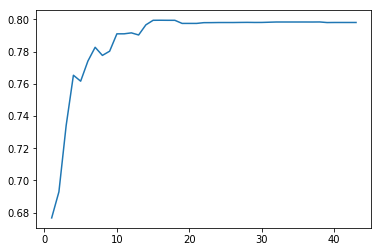

In [153]:
nof_list=np.arange(1,44)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in tqdm(range(len(nof_list))):
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
plt.plot(nof_list, score_list)
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [160]:
model = LinearRegression()
rfe = RFE(model,16)
X_train_rfe = rfe.fit_transform(X_train,y_train)
X_test_rfe = rfe.transform(X_test)
model.fit(X_train_rfe,y_train)
print(model.score(X_test_rfe,y_test))
support = rfe.support_

0.799482936583694


In [161]:
good_cols = []
for i in range(len(support)):
    if support[i]:
        good_cols.append(X_train.columns[i])
good_cols

['Non-profit hospital beds per 1000 people (2019)',
 'Total Hospitals (2019)',
 'state resturant data',
 'cases',
 'deaths',
 'deaths 1 days ago',
 'deaths 3 days ago',
 'deaths 4 days ago',
 'deaths 5 days ago',
 'deaths 6 days ago',
 'deaths 7 days ago',
 'deaths 8 days ago',
 'deaths 9 days ago',
 'neighbor2_deaths',
 'neighbor4_deaths',
 'neighbor5_deaths']

In [162]:
X_train_filtered = X_train[good_cols]
X_test_filtered = X_test[good_cols]

Ordinary Least Squares
R^2 (in sample): 0.863919
R^2 (out sample): 0.799483
Ridge Model
R^2 (in sample): 0.863919
R^2 (out sample): 0.799582
Lasso Model
R^2 (in sample): 0.858851
R^2 (out sample): 0.802579


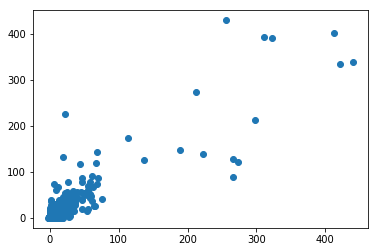

In [165]:
normal_model = LinearRegression().fit(X_train_filtered.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % normal_model.score(X_test_filtered,y_test))
ridge_model = Ridge(alpha=1000)
ridge_model.fit(X_train_filtered.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % ridge_model.score(X_test_filtered,y_test))
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train_filtered.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % lasso_model.score(X_test_filtered,y_test))
plt.scatter(ridge_model.predict(X_test_filtered), y_test)

R squared (in sample) is 0.993567
R squared (out sample) is 0.727224


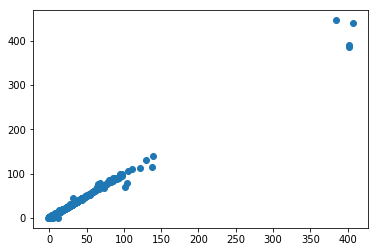

In [176]:
gbm = lgb.LGBMRegressor(n_estimators=1500,num_leaves=200);
gbm.fit(X_train_filtered, y_train,
        eval_set=[(X_test_filtered, y_test)],
        eval_metric='l2',
        verbose=False);
pred_train = gbm.predict(X_train_filtered, num_iteration=gbm.best_iteration_)
print("R squared (in sample) is %f" % Rsquare(pred_train, y_train))
pred_test = gbm.predict(X_test_filtered, num_iteration=gbm.best_iteration_)
print("R squared (out sample) is %f" % Rsquare(pred_test, y_test))
plt.scatter(pred_train, y_train)

### Predicting Cases

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cases, test_size=0.4)
X_train_filtered = X_train[good_cols]
X_test_filtered = X_test[good_cols]

Ordinary Least Squares
R^2 (in sample): 0.775023
R^2 (out sample): 0.766692
Ridge Model
R^2 (in sample): 0.775022
R^2 (out sample): 0.766743
Lasso Model
R^2 (in sample): 0.774792
R^2 (out sample): 0.769621


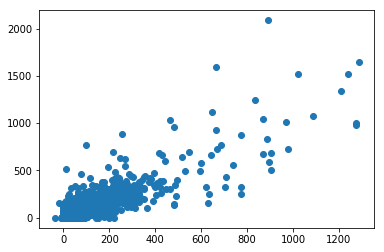

In [178]:
normal_model_cases = LinearRegression().fit(X_train_filtered.values, y_train)
print("Ordinary Least Squares")
print("R^2 (in sample): %f" % normal_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % normal_model_cases.score(X_test_filtered,y_test))
ridge_model_cases = Ridge(alpha=1000)
ridge_model_cases.fit(X_train_filtered.values, y_train)
print("Ridge Model")
print("R^2 (in sample): %f" % ridge_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % ridge_model_cases.score(X_test_filtered,y_test))
lasso_model_cases = Lasso(alpha=1)
lasso_model_cases.fit(X_train_filtered.values, y_train)
print("Lasso Model")
print("R^2 (in sample): %f" % lasso_model_cases.score(X_train_filtered,y_train))
print("R^2 (out sample): %f" % lasso_model_cases.score(X_test_filtered,y_test))
plt.scatter(ridge_model_cases.predict(X_test_filtered), y_test)

## Submission 3?

In [189]:
df_true,_ =get_XY_with_neighs(df_jhu_merged, 0, 10, delta_death_counter, fips_list=large_fips, moving_window=False, offset=0, features=features)
percentile_to_zscore = {10:-1.282, 20:-0.842,30:-0.524,40:-0.253,50:0,60:0.253,70:0.524,80:0.842,90:1.282}
df_true = df_true.set_index('fips')

In [180]:
col_names = []
for j in range(10):
    if j > 0:
        copy_col = 'deaths %d days ago' % (j)
    else:
        copy_col = 'deaths'
    col_names.append(copy_col)
def get_percentile_obj(model, X, good_cols, min_look_ahead=1, max_look_ahead=14, cases_predictor=None):
    model_neigh = neighbors.NearestNeighbors(6, n_jobs = 4).fit(X[['pclon10', 'pclat10']])
    distances, indices = model_neigh.kneighbors(X[['pclon10', 'pclat10']])
    indices = np.transpose(indices[:, 1:]) # Remove itself from the neighbors
    distances = np.transpose(distances[:, 1:])
    output = {}
    df = X.copy()
    for i in range(min_look_ahead, max_look_ahead + 1):
        pred = model.predict(df[good_cols].values)  # Unbiased prediction
        std_prev = np.std(df[col_names].values,axis=1) # standard deviation of prediction
        pred = np.random.normal(pred,std_prev) # draw from normal dist
        pred = pred.clip(min=0) # No negative deaths!

        if cases_predictor is not None:
            pred_cases = cases_predictor.predict(df[good_cols].values) # Num case predictions
            pred_cases = pred_cases.clip(min=0) #no negative cases
            df['cases'] = pred_cases 
        fips_to_pred = {}
        for j in range(len(df.index)):
            fips = df.index[j]
            if pred[j] < 0:
                fips_to_pred[fips] = 0
            else:
                fips_to_pred[fips] = pred[j]
        for j in range(9,0,-1):
            df[col_names[j]] = df[col_names[j-1]] # Shift the columns to simulate the progress of a day
        df['deaths'] = pred

        # Updating neighbor case/death counts 
        for j in range(5): 
            data = df.iloc[indices[j]]
            df['neighbor'+str(j+1)+'_'+'deaths'] = data['deaths'].values 
            df['neighbor'+str(j+1)+'_'+'cases'] = data['cases'].values
        deaths = df['deaths'].values[indices]
        cases = df['cases'].values[indices]
        truncated_distances = distances.copy()
        truncated_distances[truncated_distances > 0.65] = np.nan
        df['deaths_in_radius'] = np.sum(deaths* (distances <= 0.65) , axis = 0)
        df['cases_in_radius'] = np.sum(cases* (distances <= 0.65) , axis = 0)
        
        output[i] = fips_to_pred
    return output
def get_percentile_obj_rand(model, X, good_cols, min_look_ahead=1, max_look_ahead=14,cases_predictor=None):
    num_samples = 200
    dummy = get_percentile_obj(model, X, good_cols, min_look_ahead=min_look_ahead, max_look_ahead=max_look_ahead,
                              cases_predictor=cases_predictor)
    freq = {}
    output = {}
    for key in dummy.keys():
        freq[key] = {}
        output[key] = {}
        for fip in dummy[key].keys():
            freq[key][fip] = [dummy[key][fip]]
            output[key][fip] = {}
    for i in tqdm(range(num_samples)):
        dummy = get_percentile_obj(model, X, good_cols, min_look_ahead=min_look_ahead, max_look_ahead=max_look_ahead)
        for key in dummy.keys():
            for fip in dummy[key].keys():
                freq[key][fip].append(dummy[key][fip])
    for key in dummy.keys():
        for fip in dummy[key].keys():
            for percentile in range(10, 100, 10):
                output[key][fip][percentile] = np.percentile(freq[key][fip], percentile, axis=0)
    return output

In [190]:
output = get_percentile_obj(ridge_model, df_true,good_cols, max_look_ahead=14,cases_predictor=normal_model_cases)
output_rand = get_percentile_obj_rand(ridge_model, df_true, good_cols, max_look_ahead=14)

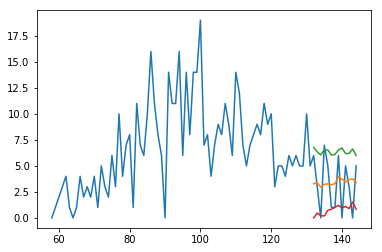

In [194]:
fips = 53033
y_50 = []
y_10 = []
y_90 = []
for i in range(1,14):
    y_50.append(output_rand[i][fips][50])
    y_10.append(output_rand[i][fips][10])
    y_90.append(output_rand[i][fips][90])

t, ys = delta_death_counter.getY(fips)
plt.plot(t,ys)
plt.plot(t[-14] +  range(1,14),y_50)
plt.plot(t[-14] +  range(1,14),y_90)
plt.plot(t[-14] +  range(1,14),y_10)

In [149]:
df_sample_sub = pd.read_csv(f"{homedir}/sample_submission.csv")
df_sample_sub['fips'] = df_sample_sub['id'].map(lambda i : int(i[11:]))
output_fips = df_sample_sub.fips.unique()
def truncate(dec):
    return int(100*dec)/100
import datetime
def write_percentiles(percentile_obj, file_name, look_back_time, look_ahead_time, prediction_limit, offset=0):
    with open(file_name, mode='w') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['id', '10', '20', '30', '40', '50', '60', '70', '80', '90'])

        today = datetime.date.today() + datetime.timedelta(days=-offset);   
        for i in range(-look_back_time, 0):
            target_day = today + datetime.timedelta(days=i)
            string_pre = target_day.strftime('%Y-%m-%d-')
            for fips in output_fips:
                print_lst = [string_pre + str(fips)]
                try:
                    X, y = delta_death_counter.getY(fips)
                    y = y.values
                    for j in range(9):
                        print_lst.append(y[i-offset])
                except:
                    for j in range(9):
                        print_lst.append(0)
                writer.writerow(print_lst)
        for delta_y in range(1, look_ahead_time):
            target_day = today + datetime.timedelta(days=delta_y-1)
            string_pre = target_day.strftime('%Y-%m-%d-')
            if delta_y > prediction_limit:
                for fips in output_fips:
                    l = [string_pre + str(fips)]
                    writer.writerow(l + [0] * 9)
                continue
            for fips in output_fips:
                print_lst = [string_pre + str(fips)]
                if fips in percentile_obj[delta_y].keys():
                    for percentiles in range(10,100,10):
                        datum = percentile_obj[delta_y][fips][percentiles]
                        if datum < 0:
                            datum = 0
                        print_lst.append(truncate(datum))
                else:
                    for i in range(9):
                        print_lst.append(0)
                writer.writerow(print_lst)

In [196]:
write_percentiles(output_rand, 'submission_test.csv', 54, 38, 14, offset=0)
your_submission = pd.read_csv('submission_test.csv').set_index('id').sort_index()
sample_submission = pd.read_csv(f"{homedir}/sample_submission.csv").set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))

# Submission 2

In [ ]:
# Get a list of OLS trained models
def train_models(fips_set, good_cols, min_look_ahead=1, max_look_ahead=14,offset=0):
    models = []
    for delta_y in range(min_look_ahead, max_look_ahead + 1):
        X,y = get_XY_with_neighs(df_jhu_merged, features, delta_y, 5, delta_death_counter, fips_list=fips_set, moving_window=True,offset=offset)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        X_test = X_test[good_cols]
        X_train = X_train[good_cols]
        model = sm.OLS(y_train,X_train)
        print("Training model to predict %d days in the future" % delta_y)
        result = model.fit()
        print("R squared (out sample) is %f" % (Rsquare(result.predict(X_test), y_test)))
        models.append(result)
    return  models

In [ ]:
model_list = train_models(large_fips, good_cols,offset=0)

In [ ]:
def get_param_info(models, min_look_ahead=1, max_look_ahead=14):
    params_mu = {}
    params_stderr = {}
    for i in range(len(models)):
        model = models[i]
        params_mu[i + min_look_ahead] = model.params
        params_stderr[i + min_look_ahead] = model.bse
    return params_mu, params_stderr

In [ ]:
param_mu, param_stderr = get_param_info(model_list)

In [ ]:
df_true,_ =get_XY_with_neighs(df_jhu_merged, features, 0, 5, delta_death_counter, fips_list=large_fips, moving_window=False)
X_true = df_true[good_cols +['fips']]
X_true = X_true.set_index('fips')
X_true.head()

In [ ]:
def gen_percentiles(X, param_mu, param_stderr, fips_list, min_look_ahead=1, max_look_ahead=14):
    output = {}
    for i in range(min_look_ahead, max_look_ahead + 1):
        n_samples = 400
        fips_to_samples = {}
        fips_to_percentiles = {}
        for fips in X.index:
            fips_to_samples[fips] = []
            fips_to_percentiles[fips] = {}
        for j in range(n_samples):
            param_sample = np.random.normal(param_mu[i], param_stderr[i])
            res = np.matmul(X.values, param_sample)
            for k in range(len(X.index)):
                fip = X.index[k]
                fips_to_samples[fip].append(res[k])
        for fips in X.index:
            for percentile in range(10, 100, 10):
                fips_to_percentiles[fips][percentile] = np.percentile(fips_to_samples[fips], percentile, axis=0)
        output[i] = fips_to_percentiles
    return output

In [ ]:
percentiles = gen_percentiles(X_true, param_mu, param_stderr, large_fips, 1, 14)

In [ ]:
write_percentiles(percentiles, 'submission_bob.csv', 39, 53, 14, offset=0)
your_submission = pd.read_csv('submission.csv').set_index('id').sort_index()
sample_submission = pd.read_csv(f"{homedir}/sample_submission.csv").set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))

## Some Sanity?

In [ ]:
model_list_offset = train_models(large_fips, good_cols,offset=7)

In [ ]:
param_mu, param_stderr = get_param_info(model_list_offset)

In [ ]:
df_true,_ =get_XY_with_neighs(df_jhu_merged, features, 0, 5, delta_death_counter, fips_list=large_fips, moving_window=False,offset=7)
X_true = df_true[good_cols+['fips']]
X_true = X_true.set_index('fips')
X_true.head()

In [ ]:
percentiles_offset = gen_percentiles(X_true, param_mu, param_stderr, large_fips, 1, 14)

In [ ]:
write_percentiles(percentiles, 'submission_offset.csv', 39, 53, 14, offset=0)

In [ ]:
your_submission = pd.read_csv('submission_offset.csv').set_index('id').sort_index()
sample_submission = pd.read_csv(f"{homedir}/sample_submission.csv").set_index('id').sort_index()
assert(your_submission.index.equals(sample_submission.index))

In [ ]:
percentiles_offset[14][36061][90]

## Submission Using LGBM

In [ ]:
print(good_cols)

In [ ]:
# Get a list of OLS trained models
def train_models(fips_set, good_cols, min_look_ahead=1, max_look_ahead=14,offset=0):
    models = []
    for delta_y in range(min_look_ahead, max_look_ahead + 1):
        X,y = get_XY_with_neighs(df_jhu_merged, features, delta_y, 5, delta_death_counter, fips_list=large_fips, moving_window=False,offset=offset)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        X_test = X_test[good_cols]
        X_train = X_train[good_cols]
        gbm = lgb.LGBMRegressor(num_leaves=10,
                        learning_rate=0.05,
                        n_estimators=100);
        print("Training model to predict %d days in the future" % delta_y)
        gbm.fit(X_train, y_train, verbose=False);
        print("R squared (out sample) is %f" % (gbm.score(X_test, y_test)))
        models.append(gbm)
    return  models

In [ ]:
models = train_models(large_fips, good_cols, offset=5)